У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
pip install darts

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift
from sklearn.metrics import mean_absolute_error, mean_squared_error
from darts.metrics import mape
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.models import ExponentialSmoothing
from darts.models import ARIMA
from darts.models import AutoARIMA
import pmdarima as pm


In [113]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/kwiga files/train.csv')


In [114]:
df['date'] = pd.to_datetime(df['date'])

In [115]:
df = df.set_index('date')

In [116]:
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



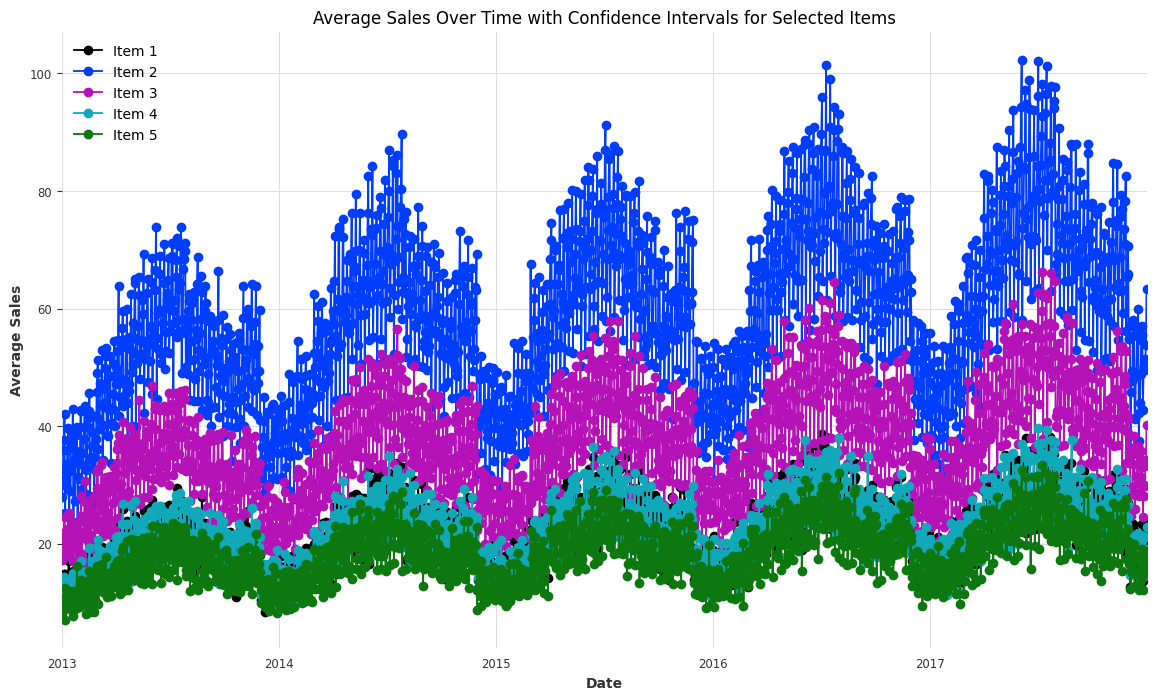

In [118]:
items_to_analyze = df['item'].unique()[:5]


plt.figure(figsize=(14, 8))
for item in items_to_analyze:
    item_df = df[df['item'] == item].groupby('date')['sales'].mean()
    item_df.plot(label=f'Item {item}', marker='o')

plt.title('Average Sales Over Time with Confidence Intervals for Selected Items')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

**Висновок:**
- Графік показує середні продажі для кількох айтемів (1, 2, 3,4,5) з плином часу.
-Ми можемо бачити загальні тенденції для кожного айтема, деякі з яких можуть показувати сезонні коливання або періодичні зміни в попиті. Всі  айтеми мають схожу динаміку з певними коливаннями, що може вказувати на загальні ринкові тренди або схожі характеристики цих товарів.
- Чітко видно повторювані цикли з піками і спадами, які відбуваються приблизно раз на рік. Це вказує на наявність сезонності у продажах всіх показаних айтемів. Можна припустити, що попит на ці товари збільшується в певні періоди року і знижується в інші.
- Незважаючи на сезонні коливання, загальний рівень продажів кожного айтема залишається досить стабільним протягом всього періоду, з невеликими змінами. Немає ознак значного зростання або падіння середніх продажів у довгостроковій перспективі.
- серед вибірки з перших 5-ти айтемів можна чітко бачити який айтем продається найкраще,а який найгірше: на графіку видно, що крива середніх значень для айтема 2 постійно знаходиться вище, ніж для інших айтемів, це може свідчити про те, що айтем 2  купують найбільше, а айтем 5 найменше.


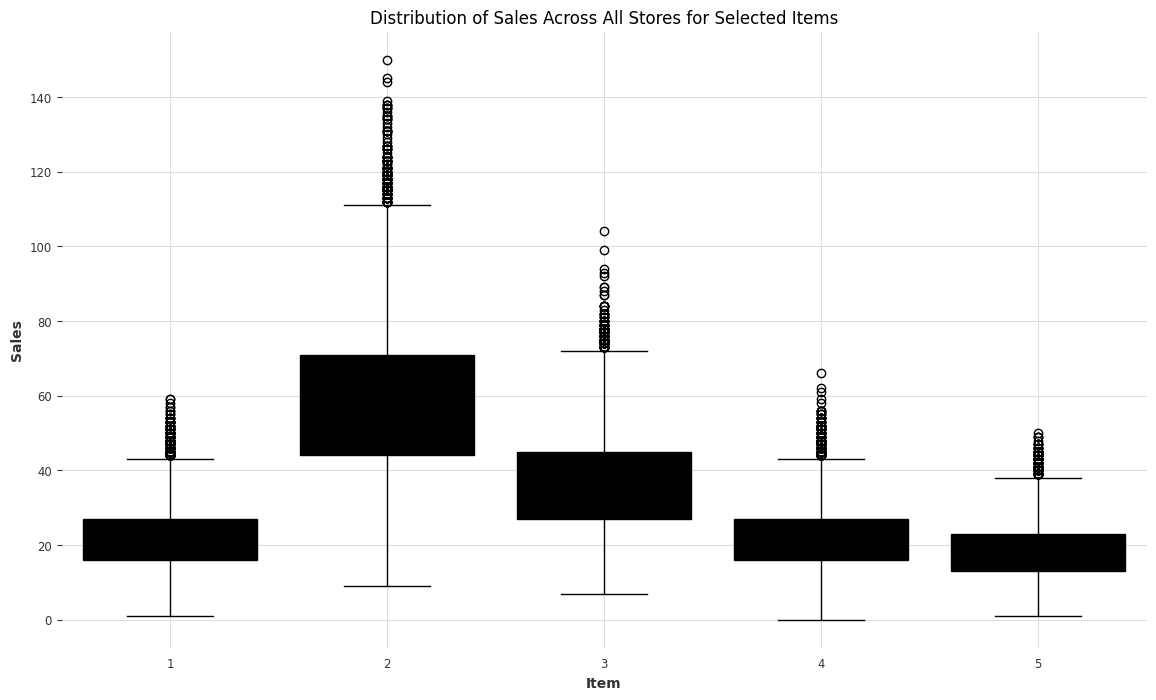

In [119]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[df['item'].isin(items_to_analyze)], x='item', y='sales')
plt.title('Distribution of Sales Across All Stores for Selected Items')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

**Висновок**
- Boxplot показує розподіл продажів для  айтемів 1, 2, 3, 4 та 5 у всіх магазинах. Ми бачимо, що середній рівень продажів (медіана)  відрізняється між айтемами, і деякі з них мають більшу варіабельність. Це може вказувати на те, що деякі товари продаються більш стабільно, тоді як інші мають коливання, що залежать від зовнішніх факторів.
- Також ми бачимо можливі аномальні значення (викиди), які можуть вимагати додаткового аналізу.
- графік також підтверджує, що айтем 2 продається більше ніж інші, тоді як 5 айтем - найменше

<ipython-input-120-8e273365d7f2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=item_sales_total, x='store', y='sales', palette='viridis')


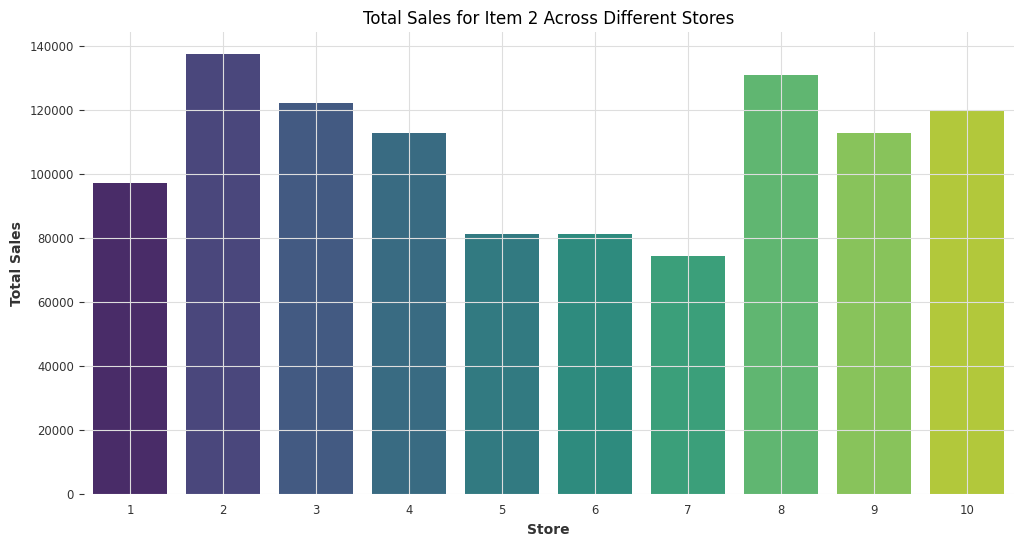

In [120]:
item_to_plot = 2
item_sales_total = df[df['item'] == item_to_plot].groupby('store')['sales'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(data=item_sales_total, x='store', y='sales', palette='viridis')
plt.title(f'Total Sales for Item {item_to_plot} Across Different Stores')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

***Висновок***:
- можна за допомогою графіка вище розглянути продаж кожного айтему у всіх магазинах. Я обрала айтем 2
- магазини 2, 3, 8, і 10 мають найвищі продажі айтема 2, що вказує на їх високу ефективність у просуванні цього товару або на більшу кількість потенційних покупців у цих локаціях. Магазини 5, 6, і 7 потребують додаткового аналізу та, можливо, коригування маркетингових стратегій для підвищення продажів айтема 2.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [121]:
subset = df[(df['item'] == 1) & (df['store'] == 1)]
subset_filtered = subset.loc[subset.index >= '2016-01-01']

subset_filtered = subset_filtered[['sales']]

subset_filtered.head()


,sales
date,
2016-01-01,21
2016-01-02,13
2016-01-03,12
2016-01-04,12
2016-01-05,12


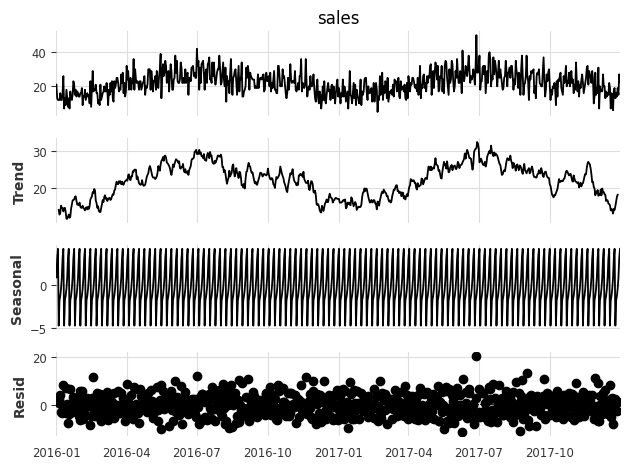

In [122]:
# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(subset_filtered['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

**Висновки з візуалізацій**:

-  Тренд: Зміни в тренді показують, що були періоди зростання та спаду, але загальна тенденція в кінці періоду показує деяке відновлення.
- На графіку видно чітку сезонну складову, яка має регулярний патерн із підйомами і спадами, що можуть бути пов'язані з щомісячною або щорічною циклічністю продажів.
- Залишкові значення на графіку виглядають випадково розподіленими, що є хорошим показником, оскільки означає, що більшість варіацій у даних пояснено трендом і сезонністю.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [123]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(subset_filtered, value_cols='sales')

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

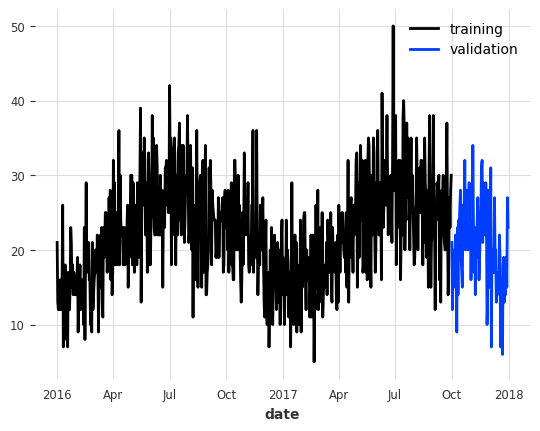

In [124]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

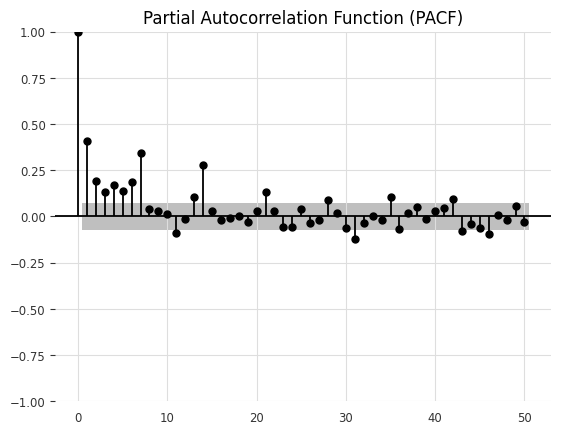

In [125]:
series_values = series.univariate_values()

plt.figure(figsize=(10, 6))
plot_pacf(series_values, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Висновок**:
Лаги 1-8,11,14,21,28,31,35, 42,43, 46 є важливими.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [126]:
is_seasonal, period = check_seasonality(train, max_lag=365, alpha=0.05)

if is_seasonal:
    print(f"Тренувальний ряд має сезонність з періодом: {period}")
else:
    print("Сезонність не виявлена.")

Тренувальний ряд має сезонність з періодом: 7


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

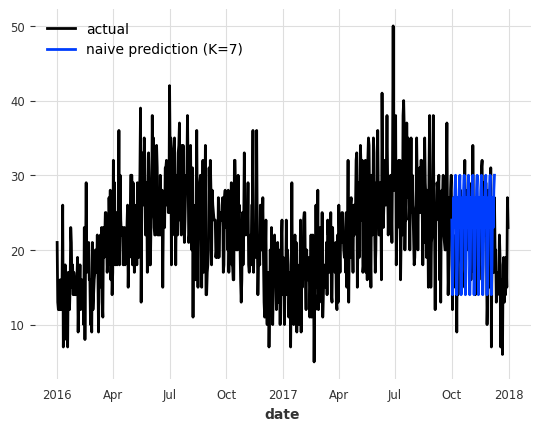

In [127]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(70)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

<Axes: xlabel='date'>

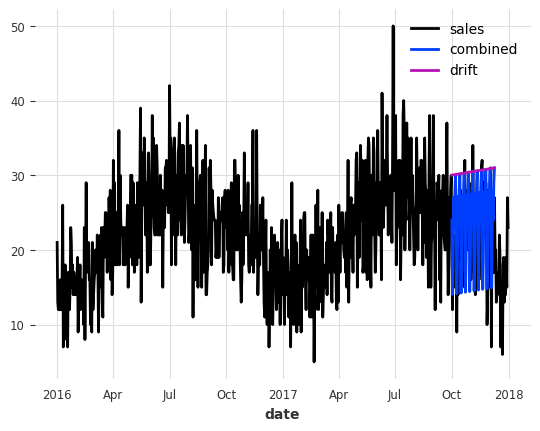

In [128]:
seasonal_model = NaiveSeasonal(K=7)
drift_model = NaiveDrift()

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(70)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

**Висновок:**
- комбінована наївна модель не показує достатньо високої точності для прогнозування складних часових рядів
-комбінована модель не захоплює всі основні патерни в даних. Прогноз  суттєво відрізняється від фактичних значень. Це вказує на те, що модель може неадекватно враховувати складніші структури в даних, такі як різкі коливання або зміни в трендах.
- на графіку видно, що прогноз не відображає важливих змін у даних, особливо якщо є різкі піки або спади.
-модель може бути корисною для простих або короткострокових прогнозів, але для більш довгострокових або складніших випадків потрібен інший підхід- застосування більш складних моделей

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [129]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)

drift_model = NaiveDrift()
drift_model.fit(train)


seasonal_forecast = seasonal_model.predict(len(val))
drift_forecast = drift_model.predict(len(val))


combined_forecast = seasonal_forecast + drift_forecast - train.last_value()

# Обчислення MAPE для комбінованого прогнозу
mape_error = mape(val, combined_forecast)
print(f'MAPE на валідаційному наборі (комбінована модель): {mape_error:.2f}%')

MAPE на валідаційному наборі (комбінована модель): 40.66%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

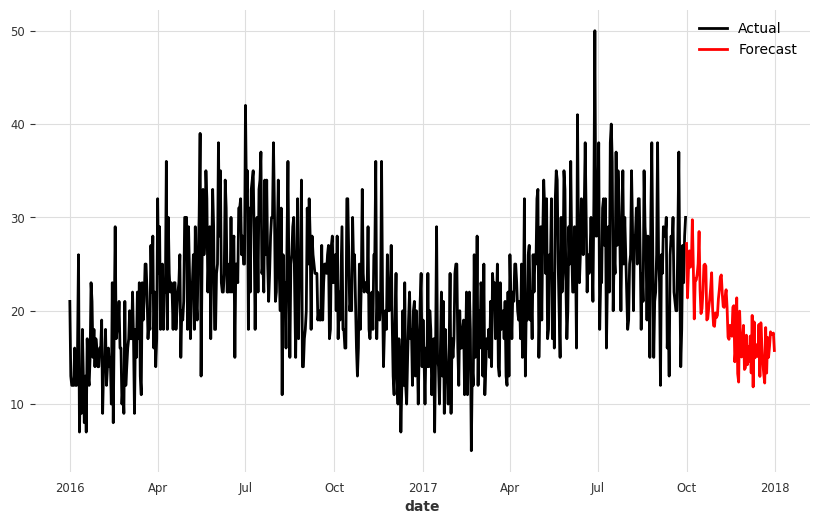

MAPE на валідаційному наборі: 27.59%


In [130]:
def enrich_with_date_features(df):

  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
  df["cos_day"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)
  return df


# Додавання ознак дати для відфільтрованих даних
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Перетворення на TimeSeries з заповненням пропущених дат
train_transformed_series = TimeSeries.from_dataframe(train_transformed, time_col='date', value_cols='sales', fill_missing_dates=True, freq='D')
val_transformed_series = TimeSeries.from_dataframe(val_transformed, time_col='date', value_cols='sales', fill_missing_dates=True, freq='D')

# Масштабування даних
scaler = Scaler()
train_transformed_scaled = scaler.fit_transform(train_transformed_series)
val_transformed_scaled = scaler.transform(val_transformed_series)

# Побудова моделі XGBoost
model = XGBModel(
    lags=7,  # Використання останніх 7 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=200,  # Кількість дерев у моделі
    max_depth=5,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

model.fit(train_transformed_scaled)
pred = model.predict(len(val_transformed_scaled))

# Відновлення масштабованих даних до оригінальних значень
forecast = scaler.inverse_transform(pred)

# Візуалізація результатів
plt.figure(figsize=(10, 6))
train.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

# Обчислення MAPE для оцінки якості
mape_error = mape(val_transformed_series, forecast)
print(f'MAPE на валідаційному наборі: {mape_error:.2f}%')


**Висновок**:
- Значення MAPE, яке становить приблизно 28%, вказує на те, що середня абсолютна процентна помилка є доволі значною. Це означає, що в середньому прогнозовані значення відхиляються від фактичних на 28%.
- Модель захоплює основні тренди, але її точність є середньою.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

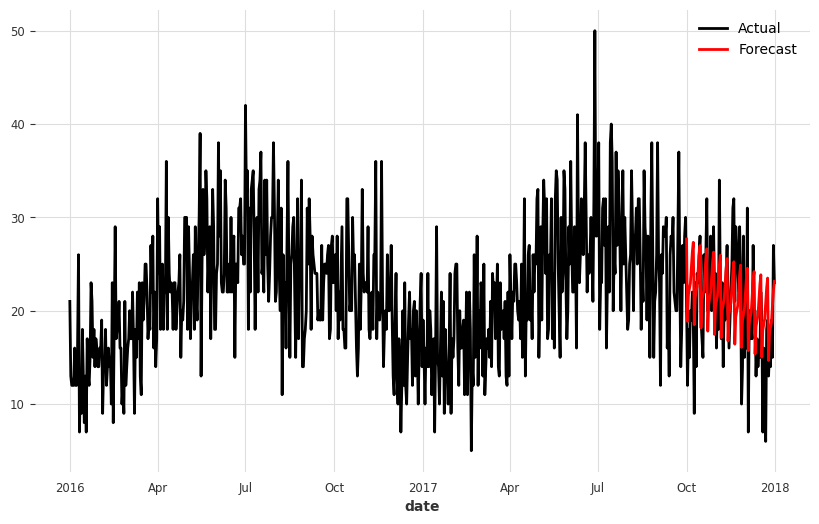

Model ExponentialSmoothing obtains MAPE: 26.55%


In [131]:

def eval_forecast(model, val, forecast):
    mape_ = mape(val, forecast)
    print(f"Model {model.__class__.__name__} obtains MAPE: {mape_:.2f}%")
    return mape_


def fit_eval_model(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    return eval_forecast(model, val, forecast)


def plot_results(series, forecast):
    plt.figure(figsize=(10, 6))
    series.plot(label='Actual')
    forecast.plot(label='Forecast', color='red')
    plt.legend()
    plt.show()


def fit_and_plot(model, series, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    plot_results(series, forecast)
    eval_forecast(model, val, forecast)


model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)


**Висновок**:
- Модель ExponentialSmoothing з поточними налаштуваннями забезпечує базовий прогноз, але з досить високим рівнем помилки (MAPE 26.55%)

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


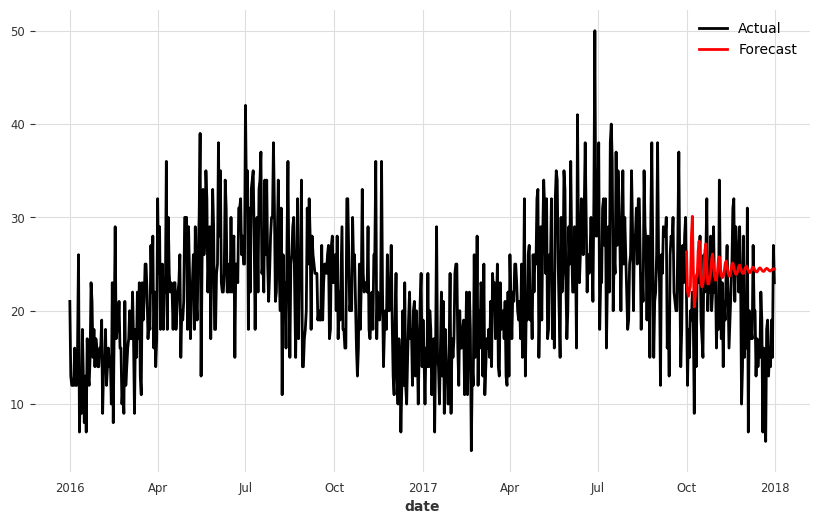

Model ARIMA obtains MAPE: 39.24%


In [132]:
model = ARIMA(p=14, d=1, q=1)
fit_and_plot(model, series, train, val)

На графіку видно, що прогнозована лінія відрізняється від фактичних значень протягом останнього відрізка часу. Це свідчить про те, що модель не змогла точно передбачити поведінку часового ряду в цей період.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4021.813, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4370.241, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4248.991, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4022.402, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4368.243, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4018.737, Time=2.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4199.129, Time=2.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4009.624, Time=4.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4153.007, Time=1.95 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4006.578, Time=3.78 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4122.945, Time=1.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4002.387, Time=0.82 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4091.271, Time=0.66 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=3994.279, Time=2.65 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

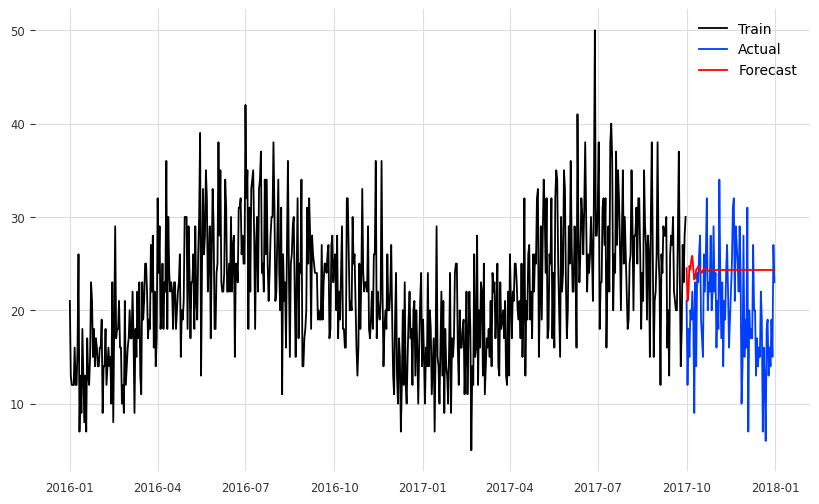

In [133]:
train_series = train.pd_series()

auto_arima_model = pm.auto_arima(train_series, start_p=1, start_q=1,
                                 max_p=30, max_q=10, m=1,
                                 start_P=0, seasonal=True,
                                 d=1, trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

print(f"Optimized ARIMA parameters: {auto_arima_model.order}")


forecast = auto_arima_model.predict(n_periods=len(val.pd_series()))


forecast_series = TimeSeries.from_times_and_values(val.time_index, forecast)


mape_error = mape(val, forecast_series)
print(f"MAPE на валідаційному наборі: {mape_error:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(train.time_index, train.pd_series(), label='Train')
plt.plot(val.time_index, val.pd_series(), label='Actual')
plt.plot(val.time_index, forecast_series.pd_series(), label='Forecast', color='red')
plt.legend()
plt.show()


**Висновок:**
- результат не покращився
- дані можуть мати нестабільний тренд або високу варіабельність, що робить передбачення складним завданням для ARIMA
-можливо, отримані параметри не оптимальні для  даних
- дані можуть містити сезонні компоненти, які ARIMA не може адекватно врахувати без додавання сезонності

14. Натренуйте модель Prophet та зробіть висновок про її якість.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/el0b4jy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/dzodzacg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17411', 'data', 'file=/tmp/tmpsb5rlz26/el0b4jy0.json', 'init=/tmp/tmpsb5rlz26/dzodzacg.json', 'output', 'file=/tmp/tmpsb5rlz26/prophet_modelgkpoxz34/prophet_model-20240825230759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


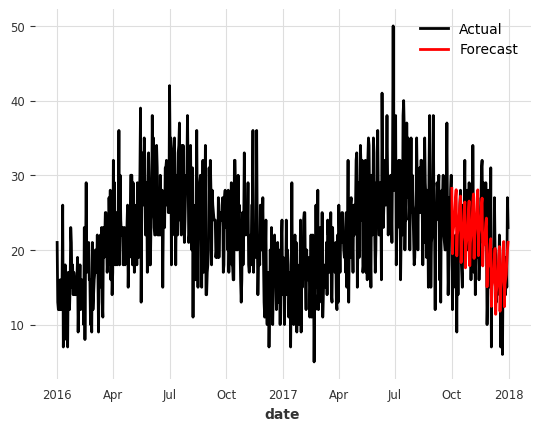

In [137]:
from darts.models import Prophet


model = Prophet(yearly_seasonality=True, daily_seasonality=True)

model.fit(train)


forecast = model.predict(len(val))


series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [138]:
eval_forecast(model, val, forecast);

Model Prophet obtains MAPE: 23.71%


15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn    

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

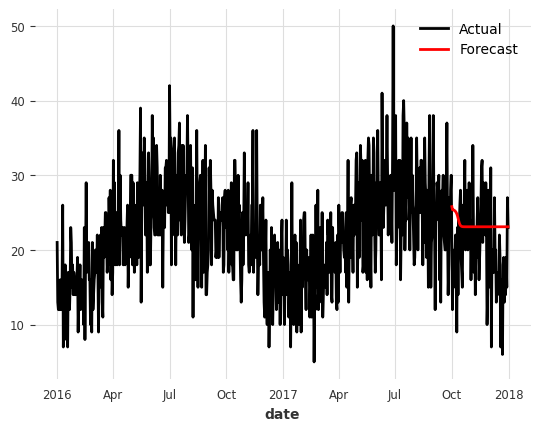

In [140]:
from darts.models import RNNModel


model = RNNModel(
    model='LSTM',
    input_chunk_length=21,
    output_chunk_length=1,
    n_epochs=200,
    random_state=42,
    dropout=0.1
)
model.fit(train)


forecast = model.predict(len(val))


series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

**Висновок**: якість моделі незадовільна, можливо потрібно ще попідбирати параметри.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/xx44mqau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/2eeze3_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59529', 'data', 'file=/tmp/tmpsb5rlz26/xx44mqau.json', 'init=/tmp/tmpsb5rlz26/2eeze3_z.json', 'output', 'file=/tmp/tmpsb5rlz26/prophet_modelivcwolzk/prophet_model-20240825232443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 0/363 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/_i6pk7v8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsb5rlz26/lcf4lrcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBU

MAPE = 21.09%


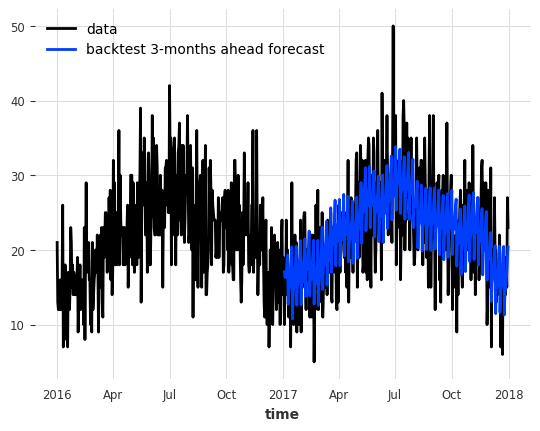

In [145]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(train)
forecast = model.predict(len(val))

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01'"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")


Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Для цієї задачі підходять моделі, здатні враховувати різні патерни та взаємозв’язки між продажами різних айтемів і магазинів. Я б розглянула використання моделей:
- Prophet для кожного окремого айтема в кожному магазині.
- XGBoost або LightGBM з додатковими ознаками, що враховують сезонність, тренд, взаємозв’язки між айтемами і магазинами.
- RNN/LSTM моделі для захоплення часової залежності.

Для кожного айтема в кожному магазині можна тренувати окрему модель. Це забезпечує максимальну гнучкість і дозволяє адаптуватися до специфіки кожного набору даних (айтома і магазину).
Всього 50 айтемів * 10 магазинів = 500 моделей.

Можна також тренувати одну складну модель (наприклад, XGBoost), яка буде враховувати всі айтеми і магазини разом, використовуючи додаткові ознаки для кодування цієї інформації. Це може бути менш точно, але простіше в реалізації.